# Results from physics-informed training 
    with 2D triangle wake
- Plot sensors, interpolated, predicted.
- Plot sensor loss, divergence, momentum residue (x and y)
- Plot original data compared with predicted, show relative MSE.
- Use probe, plot frequency at locations.

In [2]:
import sys
sys.path.append('..')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".30"
from pathlib import Path
import numpy as np
import h5py
import jax
import jax.numpy as jnp
import yaml

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.interpolate import griddata

import flowrec.training_and_states as state_utils
from utils import simulation2d
import flowrec.data as data_utils
from flowrec import losses
import flowrec.physics_and_derivatives as derivatives
from utils.py_helper import slice_from_tuple

In [3]:
plt.style.use('../utils/ppt.mplstyle')

In [44]:
# results_dir = Path('../local_results/t2gpfcpm3230615161032')
results_dir = Path('../local_results/t2gpfcpm3230615230113')
# results_dir = Path('../local_results/sweep/sweep_weights_i8e2momc:v2/')
print('Does directory exist?',results_dir.exists())
! ls $results_dir

Does directory exist? True
config.yml  results.h5	state.npy  state.pkl


# Load configurations and results

In [45]:
with open(Path(results_dir,'config.yml'),'r') as f:
    cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
cfg.data_config.update({'data_dir':'.'+cfg.data_config.data_dir})

with h5py.File(Path(results_dir,'results.h5'),'r') as hf:
    loss_train = np.array(hf.get("loss_train"))
    loss_val = np.array(hf.get("loss_val"))
    loss_div = np.array(hf.get("loss_div"))
    loss_momentum = np.array(hf.get("loss_momentum"))
    loss_sensors = np.array(hf.get("loss_sensors"))

## Load data

In [46]:
x_base = 132
triangle_base_coords = [49,80]
(ux,uy,pp) = simulation2d.read_data(cfg.data_config.data_dir,x_base)
x = np.stack([ux,uy,pp],axis=0)
# remove parts where uz is not zero
s = slice_from_tuple(cfg.data_config.slice_to_keep)
x = x[s]


## partition data
[x_train,x_val,x_test], _ = data_utils.data_partition(x,
    1,
    cfg.data_config.train_test_split,
    REMOVE_MEAN=cfg.data_config.remove_mean,
    randseed=cfg.data_config.randseed,
    SHUFFLE=cfg.data_config.shuffle
) # Do not shuffle, do not remove mean for training with physics informed loss


[ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
[ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
[ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))


## normalise
if cfg.data_config.normalise:
    [ux_train_normal,uy_train_normal,pp_train_normal], train_minmax = data_utils.normalise(ux_train,uy_train,pp_train)
    [ux_val_normal,uy_val_normal,pp_val_normal], val_minmax = data_utils.normalise(ux_val,uy_val,pp_val)
    [ux_test_normal,uy_test_normal,pp_test_normal], test_minmax = data_utils.normalise(ux_test,uy_test,pp_test)
    ## take input
    pb_train = simulation2d.take_measurement_base(pp_train_normal,ly=triangle_base_coords,centrex=0)
    pb_val = simulation2d.take_measurement_base(pp_val_normal,ly=triangle_base_coords,centrex=0)
    pb_test = simulation2d.take_measurement_base(pp_test_normal,ly=triangle_base_coords,centrex=0)
else:
    ## take input
    pb_train = simulation2d.take_measurement_base(pp_train,ly=triangle_base_coords,centrex=0)
    pb_val = simulation2d.take_measurement_base(pp_val,ly=triangle_base_coords,centrex=0)
    pb_test = simulation2d.take_measurement_base(pp_test,ly=triangle_base_coords,centrex=0)


# information about the grid
datainfo = data_utils.DataMetadata(
    re = cfg.data_config.re,
    discretisation=[cfg.data_config.dt,cfg.data_config.dx,cfg.data_config.dy],
    axis_index=[0,1,2],
    problem_2d=True
).to_named_tuple()

pb_train = np.reshape(pb_train,(cfg.data_config.train_test_split[0],-1))
pb_val = np.reshape(pb_val,(cfg.data_config.train_test_split[1],-1))
pb_test = np.reshape(pb_test,(cfg.data_config.train_test_split[2],-1))

u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
u_val = np.stack((ux_val,uy_val,pp_val),axis=-1)
u_test = np.stack((ux_test,uy_test,pp_test),axis=-1)



In [47]:
## measure
take_observation, insert_observation = cfg.case.observe(cfg.data_config, example_pred_snapshot=u_train[0,...],example_pin_snapshot=pb_train[0,...])
observed_train = take_observation(u_train)
observed_val = take_observation(u_val)
observed_test = take_observation(u_test)

### Noisy data

In [48]:
if cfg.data_config.snr:
    std_data = np.std(x,axis=(1,2,3),ddof=1)
    snr_l = 10.**(cfg.data_config.snr/10.)
    # snr_l = 10.**(20/10.)
    std_n = np.sqrt(std_data**2/snr_l)
    noise_ux = np.random.normal(scale=std_n[0],size=x[0,...].shape)
    noise_uy = np.random.normal(scale=std_n[1],size=x[1,...].shape)
    noise_pp = np.random.normal(scale=std_n[2],size=x[2,...].shape)
    noise = np.stack([noise_ux,noise_uy,noise_pp],axis=0)
    x_noisy = x + noise
else:
    x_noisy = x

[x_train_n,x_val_n,x_test_n], _ = data_utils.data_partition(x_noisy,
    1,
    cfg.data_config.train_test_split,
    REMOVE_MEAN=cfg.data_config.remove_mean,
    randseed=cfg.data_config.randseed,
    SHUFFLE=cfg.data_config.shuffle
) # Do not shuffle, do not remove mean for training with physics informed loss
[ux_train_n,uy_train_n,pp_train_n] = np.squeeze(np.split(x_train_n,3,axis=0))
[ux_val_n,uy_val_n,pp_val_n] = np.squeeze(np.split(x_val_n,3,axis=0))
[ux_test_n,uy_test_n,pp_test_n] = np.squeeze(np.split(x_test_n,3,axis=0))

## normalise
if cfg.data_config.normalise:
    [ux_train_normal_n,uy_train_normal_n,pp_train_normal_n], train_minmax = data_utils.normalise(ux_train_n,uy_train_n,pp_train_n)
    [ux_val_normal_n,uy_val_normal_n,pp_val_normal_n], val_minmax = data_utils.normalise(ux_val_n,uy_val_n,pp_val_n)
    [ux_test_normal_n,uy_test_normal_n,pp_test_normal_n], test_minmax = data_utils.normalise(ux_test_n,uy_test_n,pp_test_n)
    ## take input
    pb_train = simulation2d.take_measurement_base(pp_train_normal_n,ly=triangle_base_coords,centrex=0)
    pb_val = simulation2d.take_measurement_base(pp_val_normal_n,ly=triangle_base_coords,centrex=0)
    pb_test = simulation2d.take_measurement_base(pp_test_normal_n,ly=triangle_base_coords,centrex=0)
else:
    ## take input
    pb_train = simulation2d.take_measurement_base(pp_train_n,ly=triangle_base_coords,centrex=0)
    pb_val = simulation2d.take_measurement_base(pp_val_n,ly=triangle_base_coords,centrex=0)
    pb_test = simulation2d.take_measurement_base(pp_test_n,ly=triangle_base_coords,centrex=0)

pb_train = np.reshape(pb_train,(cfg.data_config.train_test_split[0],-1))
pb_val = np.reshape(pb_val,(cfg.data_config.train_test_split[1],-1))
pb_test = np.reshape(pb_test,(cfg.data_config.train_test_split[2],-1))

u_train_n = np.stack((ux_train_n,uy_train_n,pp_train_n),axis=-1)
u_val_n = np.stack((ux_val_n,uy_val_n,pp_val_n),axis=-1)
u_test_n = np.stack((ux_test_n,uy_test_n,pp_test_n),axis=-1)

## measure
observed_train = take_observation(u_train_n)
observed_val = take_observation(u_val_n)
observed_test = take_observation(u_test_n)

In [49]:
t_plt = 20

## Visualise input data
Sensors and interpolated flow field.

In [50]:
observed_plot = np.empty_like(u_train)
observed_plot.fill(np.nan)
observed_plot = insert_observation(jnp.asarray(observed_plot),jnp.asarray(observed_train))

measurements = []
for i in range(observed_plot.shape[-1]):
    measurements.append(observed_plot[t_plt,...,i][~np.isnan(observed_plot[t_plt,...,i])])

In [51]:
measurements[0].shape

(442,)

In [52]:
# Get sensor coordinates
sensors_empty = np.empty_like(u_train[[0],...])
sensors_empty.fill(np.nan)

grid_x,grid_y = np.mgrid[0:ux_train.shape[1], 0:ux_train.shape[2]]

gridx1 = np.repeat(grid_x[None,:,:,None],3,axis=3)
gridy1 = np.repeat(grid_y[None,:,:,None],3,axis=3)

idx_x = take_observation(gridx1)
idx_y = take_observation(gridy1)

idx_x = insert_observation(jnp.asarray(sensors_empty),jnp.asarray(idx_x))[0,...]
sensors_loc_x = []
for i in range(idx_x.shape[-1]):
    sensors_loc_x.append(idx_x[...,i][~np.isnan(idx_x[...,i])])

idx_y = insert_observation(jnp.asarray(sensors_empty),jnp.asarray(idx_y))[0,...]
sensors_loc_y = []
for i in range(idx_y.shape[-1]):
    sensors_loc_y.append(idx_y[...,i][~np.isnan(idx_y[...,i])])


/home/ym917/miniconda3/envs/fr/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


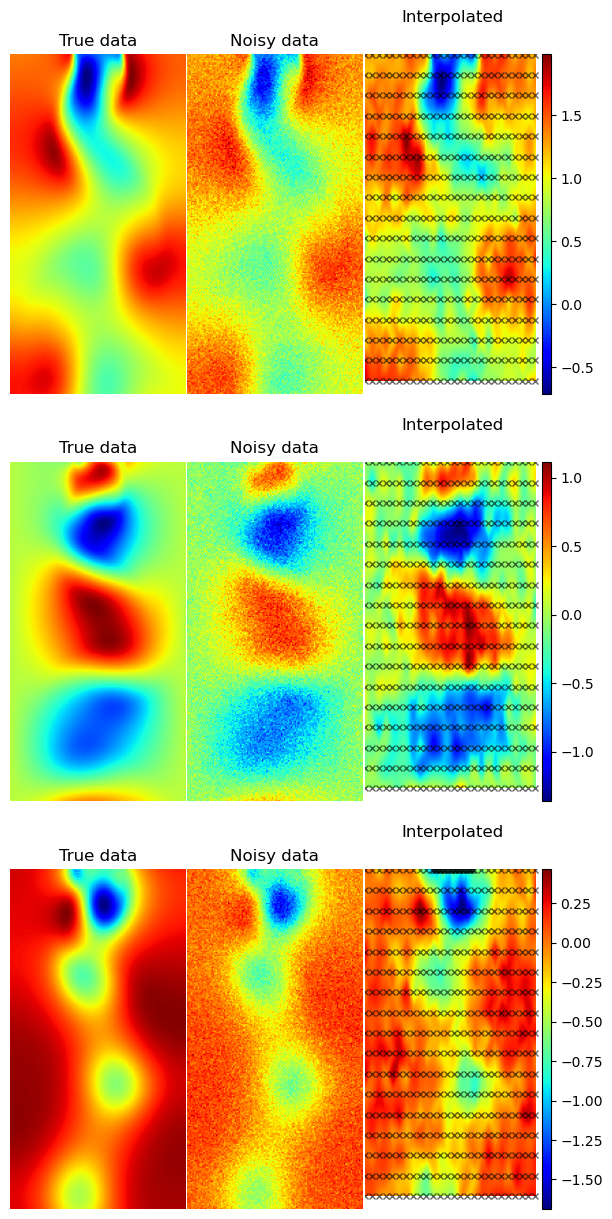

In [53]:
# plot true and interpolation
fig = plt.figure(figsize=(36,15))
axes = []
axes.append(ImageGrid(fig,311,(1,3),share_all=True,cbar_mode='single'))
axes.append(ImageGrid(fig,312,(1,3),share_all=True,cbar_mode='single'))
axes.append(ImageGrid(fig,313,(1,3),share_all=True,cbar_mode='single'))

for i in range(3):
    sensors_loc = np.stack((sensors_loc_x[i].flatten(),sensors_loc_y[i].flatten()),axis=-1)
    data_interp = griddata(sensors_loc, measurements[i].flatten(), (grid_x,grid_y), method='cubic')
    ax = axes[i]
    ax.axes_all[0].imshow(u_train[t_plt,...,i],'jet')
    ax.axes_all[0].set_title('True data')
    ax.axes_all[0].axis('off')
    
    ax.axes_all[1].imshow(u_train_n[t_plt,...,i],'jet')
    ax.axes_all[1].set_title('Noisy data')
    ax.axes_all[1].axis('off')

    im = ax.axes_all[2].imshow(data_interp,'jet')
    ax.axes_all[2].spy(observed_plot[t_plt,...,i],color='k',marker='x',markersize=5,alpha=0.6)
    ax.axes_all[2].set_title('Interpolated')
    ax.axes_all[2].axis('off')
    ax.cbar_axes[0].colorbar(im)
plt.show()

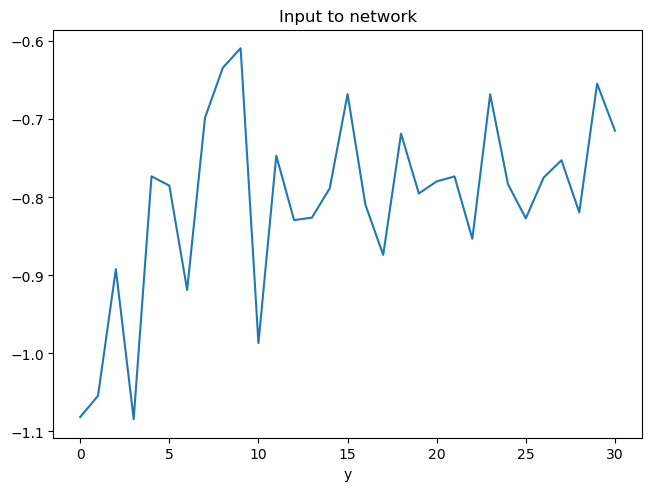

In [54]:
plt.figure()
plt.plot(pb_train[t_plt,:])
plt.title('Input to network')
plt.xlabel('y')
plt.show()

# Loss
Plot different losses:
- Sensors
- Divergence
- Momentum residue
- Total physics loss
- Total loss

Also plot relative mse of the entire predicted flow field and compare with interpolated.

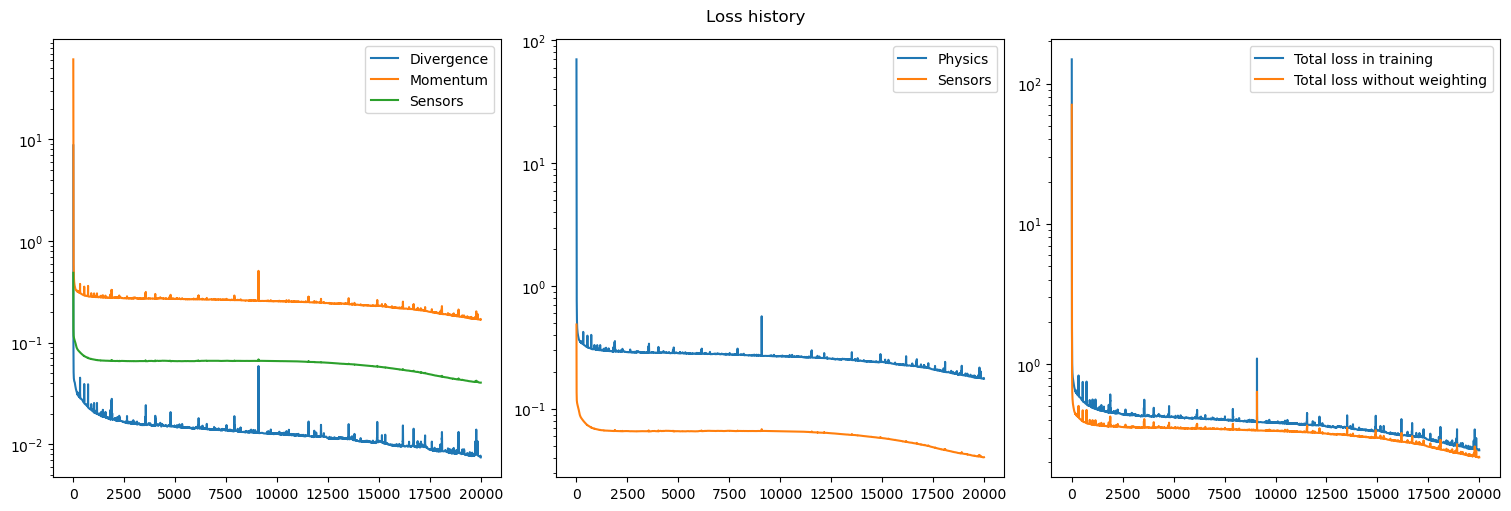

In [55]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
fig.suptitle('Loss history')
axes[0].plot(loss_div,label='Divergence')
axes[0].plot(loss_momentum,label='Momentum')
axes[0].plot(loss_sensors,label='Sensors')
axes[0].legend()
axes[0].set_yscale('log')
axes[1].plot(loss_div+loss_momentum,label='Physics')
axes[1].plot(loss_sensors,label='Sensors')
axes[1].legend()
axes[1].set_yscale('log')
axes[2].plot(loss_train,label='Total loss in training')
axes[2].plot(loss_div+loss_momentum+loss_sensors,label='Total loss without weighting')
axes[2].legend()
axes[2].set_yscale('log')
plt.show()

## Load model

In [56]:
state = state_utils.restore_trainingstate(results_dir,'state')
jax.tree_util.tree_map(lambda x: print(x.shape),state.params)

(32,)
(5, 5, 3, 32)
(16,)
(5, 5, 32, 16)
(3,)
(5, 5, 16, 3)
(96750,)
(31, 96750)


{'mlp_with_cnn/~/convolve_0': {'b': None, 'w': None},
 'mlp_with_cnn/~/convolve_1': {'b': None, 'w': None},
 'mlp_with_cnn/~/convolve_2': {'b': None, 'w': None},
 'mlp_with_cnn/~/mlp/~/linear_0': {'b': None, 'w': None}}

In [57]:
_, make_model = cfg.case.select_model(datacfg=cfg.data_config, mdlcfg=cfg.model_config, traincfg=cfg.train_config)
mdl = make_model(cfg.model_config)

In [58]:
rng = jax.random.PRNGKey(10)

pb_train_batch = np.array_split(pb_train,2,0)
pred_train = []
for inn in pb_train_batch:
    pred_train.append(mdl.apply(state.params,rng,inn,TRAINING=False))
pred_train = np.concatenate(pred_train)
pred_test = mdl.apply(state.params,rng,pb_test,TRAINING=False)
if cfg.data_config.normalise:
    pred_train = data_utils.unnormalise_group(pred_train, train_minmax, axis_data=-1, axis_range=0)
    pred_test = data_utils.unnormalise_group(pred_test, test_minmax, axis_data=-1, axis_range=0)


Calculate physics loss

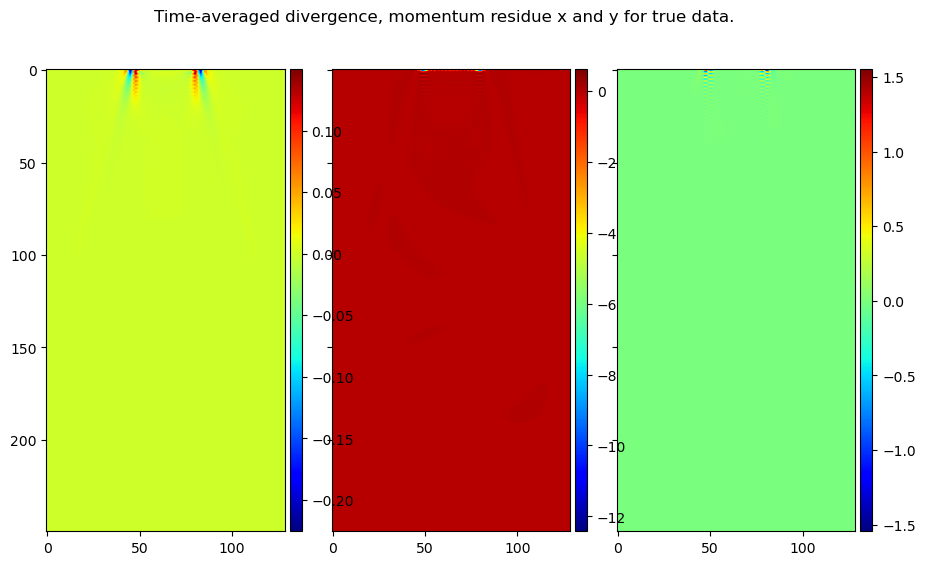

In [59]:
l_d_test = derivatives.div_field(pred_test[...,:-1],datainfo)
l_m_test = derivatives.momentum_residual_field(pred_test,datainfo)


l_d_true = derivatives.div_field(u_test[...,:-1],datainfo)
l_m_true = derivatives.momentum_residual_field(u_test,datainfo)


l_d_noisy = derivatives.div_field(u_test_n[...,:-1],datainfo)
l_m_noisy = derivatives.momentum_residual_field(u_test_n,datainfo)

fig = plt.figure(figsize=(12,6))
grid = ImageGrid(fig,111,(1,3),cbar_mode='each',axes_pad=0.3,cbar_pad=0.05)
for ax, cax, plt_data in zip(grid.axes_all, grid.cbar_axes, [l_d_true, l_m_true[0,...], l_m_true[1,...]]):
    im = ax.imshow(np.mean(plt_data,axis=0),'jet')
    cax.colorbar(im)
fig.suptitle('Time-averaged divergence, momentum residue x and y for true data.')
plt.show()

## Plot comparison between prediction and True

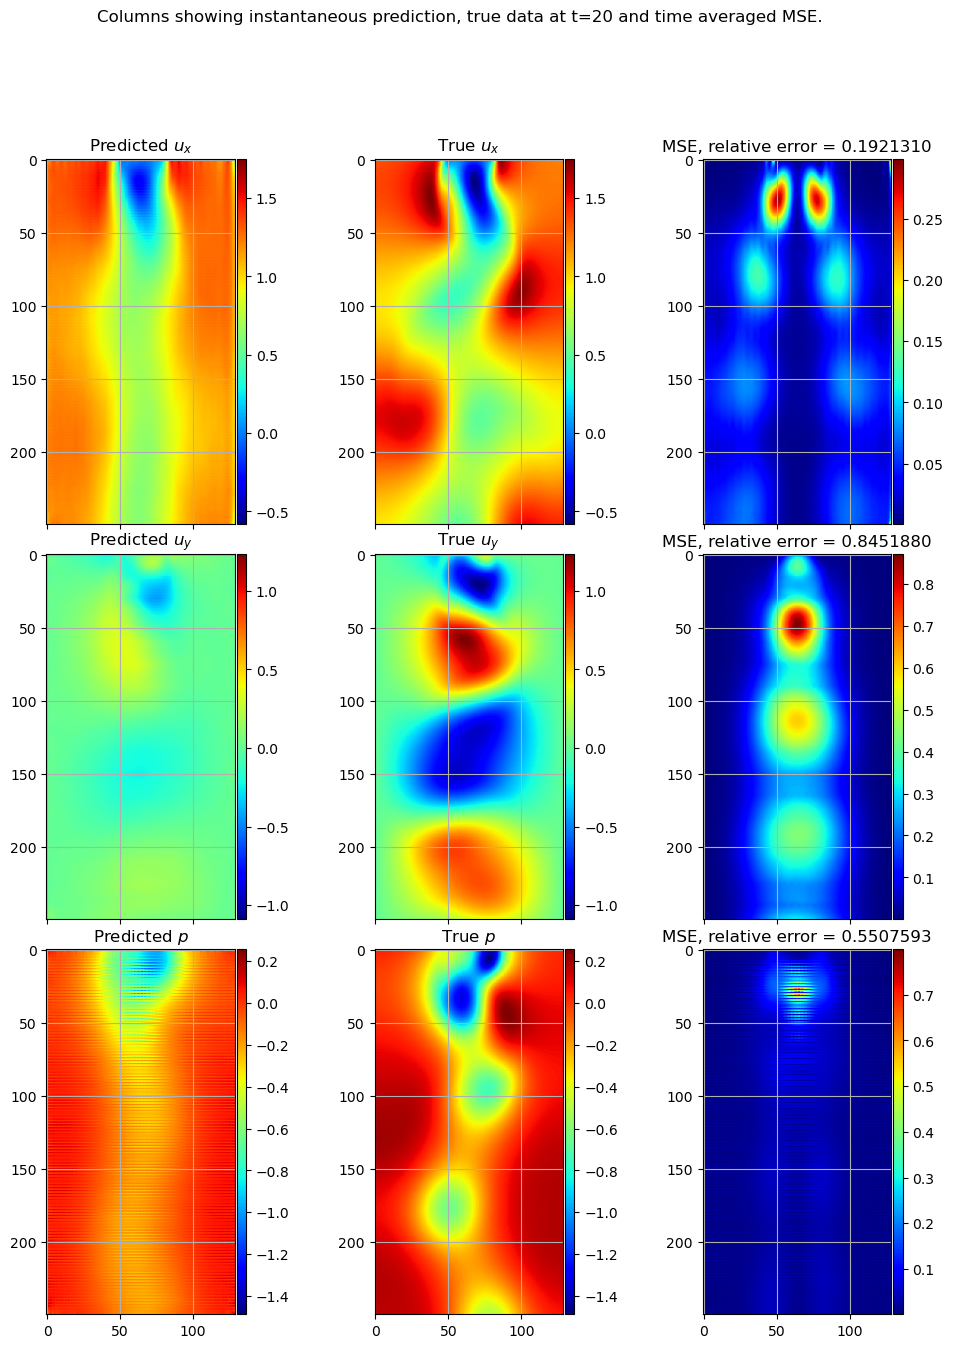

In [60]:
fig = plt.figure(figsize=(12,15))
set_name = ['$u_x$','$u_y$','$p$']

# predicted
grid1 = ImageGrid(fig,131,(3,1),cbar_mode='each',axes_pad=(0.02,0.3))
mse_plane = np.einsum('t x y i -> x y i', (pred_test-u_test)**2)/cfg.data_config.train_test_split[2]
for i, (ax,cax) in enumerate(zip(grid1[:3],grid1.cbar_axes[:3])):
    im = ax.imshow(pred_test[t_plt,:,:,i],'jet')
    ax.set_title(f'Predicted {set_name[i]}')
    cax.colorbar(im)
    ax.grid()

# true
grid2 = ImageGrid(fig,132,(3,1),cbar_mode='each',axes_pad=(0.02,0.3))
mse_plane = np.einsum('t x y i -> x y i', (pred_test-u_test)**2)/cfg.data_config.train_test_split[2]
for i, (ax,cax) in enumerate(zip(grid2[:3],grid2.cbar_axes[:3])):
    im = ax.imshow(u_test[t_plt,:,:,i],'jet')
    ax.set_title(f'True {set_name[i]}')
    cax.colorbar(im)
    ax.grid()

# loss
grid3 = ImageGrid(fig,133,(3,1),cbar_mode='each',axes_pad=(0.02,0.3))
mse_plane = np.einsum('t x y i -> x y i', (pred_test-u_test)**2)/cfg.data_config.train_test_split[2]
for i, (ax,cax) in enumerate(zip(grid3[:3],grid3.cbar_axes[:3])):
    im = ax.imshow(mse_plane[:,:,i],'jet')
    ax.set_title(f'MSE, relative error = {losses.relative_error(pred_test[...,i],u_test[...,i]):.7f}')
    cax.colorbar(im)
    ax.grid()

fig.suptitle(f'Columns showing instantaneous prediction, true data at t={t_plt} and time averaged MSE.')

for axpred, axtrue in zip(grid1.axes_all,grid2.axes_all):
    [impred] = axpred.get_images()
    [imtrue] = axtrue.get_images()
    climpred = impred.get_clim()
    climtrue = imtrue.get_clim()
    impred.set_clim(min(climpred[0],climtrue[0]),max(climpred[1],climtrue[1]))
    imtrue.set_clim(min(climpred[0],climtrue[0]),max(climpred[1],climtrue[1]))

plt.show()

Physics loss comparison

Calculate residual of the interpolated data first

In [61]:
temp_observed_test = np.empty_like(u_test)
temp_observed_test.fill(np.nan)
temp_observed_test = insert_observation(jnp.asarray(temp_observed_test),jnp.asarray(observed_test)) # observed_test is noisy if

In [62]:
compare_interp = []

for i in range(3):
    sensors_loc = np.stack((sensors_loc_x[i].flatten(),sensors_loc_y[i].flatten()),axis=-1)
    for j in range(cfg.data_config.train_test_split[2]):
        temp_measurement = temp_observed_test[j,...,i][~np.isnan(temp_observed_test[j,...,i])]
        compare_interp.append(
            griddata(sensors_loc, temp_measurement.flatten(), (grid_x,grid_y), method='cubic')
        )
compare_interp = np.array(compare_interp)
compare_interp = np.stack((compare_interp[:cfg.data_config.train_test_split[2],...],compare_interp[cfg.data_config.train_test_split[2]:2*cfg.data_config.train_test_split[2],...],compare_interp[2*cfg.data_config.train_test_split[2]:3*cfg.data_config.train_test_split[2],...]),axis=-1)
nb_elements = np.count_nonzero(~np.isnan(compare_interp[1,...,0]))
compare_interp.shape

(100, 250, 129, 3)

In [63]:
interp_physics = derivatives.div_field(compare_interp[...,:-1],datainfo=datainfo) + np.sum(derivatives.momentum_residual_field(compare_interp,datainfo=datainfo),axis=0)
# interp_physics = np.nan_to_num(interp_physics)
interp_physics.shape
# this is noisy 

(100, 250, 129)

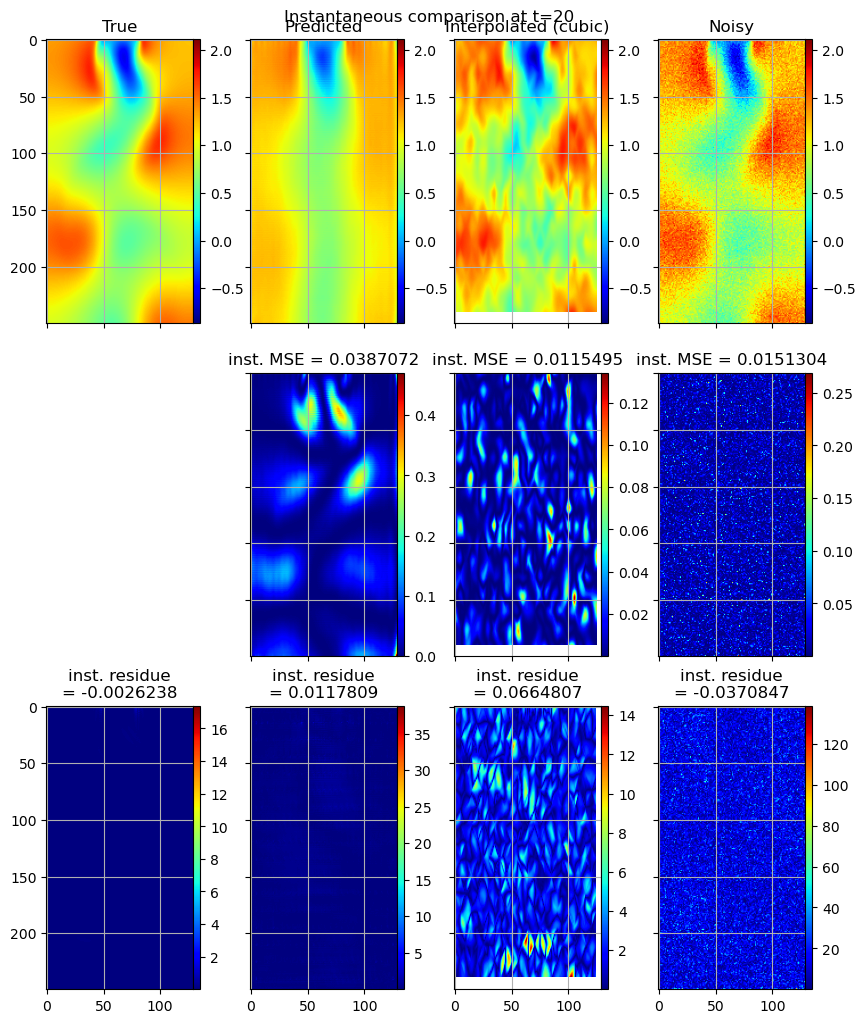

In [64]:
which_value = 0
t_compare = 20
fig = plt.figure(figsize=(10,10))
fig.suptitle(f'Instantaneous comparison at t={t_compare}')
grid = ImageGrid(fig,(0,0,1,0.95),(3,4),cbar_mode='each',axes_pad=(0.5,0.5),cbar_pad=0.005)
ax = grid.axes_all
cax = grid.cbar_axes

clim_min = []
clim_max = []

#first row
ax[0].set_title('True')
im = ax[0].imshow(u_test[t_compare,...,which_value])
clim = im.get_clim()
clim_min.append(clim[0])
clim_max.append(clim[1])
cax[0].colorbar(im)
ax[1].set_title('Predicted')
im = ax[1].imshow(pred_test[t_compare,...,which_value])
clim = im.get_clim()
clim_min.append(clim[0])
clim_max.append(clim[1])
cax[1].colorbar(im)
ax[2].set_title('Interpolated (cubic)')
im = ax[2].imshow(compare_interp[t_compare,...,which_value])
clim = im.get_clim()
clim_min.append(clim[0])
clim_max.append(clim[1])
cax[2].colorbar(im)
ax[3].set_title('Noisy')
im = ax[3].imshow(u_test_n[t_compare,...,which_value])
clim = im.get_clim()
clim_min.append(clim[0])
clim_max.append(clim[1])
cax[3].colorbar(im)

for axis in ax[:3]:
    [im] = axis.get_images()
    im.set_clim(min(clim_min),max(clim_max))


#second row
ax[4].axis('off')
cax[4].axis('off')
ax[5].set_title(f'inst. MSE = {losses.mse(pred_test[t_compare,...,which_value],u_test[t_compare,...,which_value]):.7f}')
im = ax[5].imshow((pred_test[t_compare,...,which_value]-u_test[t_compare,...,which_value])**2,'jet')
cax[5].colorbar(im)
mse_interp = np.sum(np.nan_to_num(compare_interp[t_compare,...,which_value] - u_test[t_compare,...,which_value])**2)/nb_elements
ax[6].set_title(f'inst. MSE = {mse_interp:.7f}')
im = ax[6].imshow((compare_interp[t_compare,...,which_value]-u_test[t_compare,...,which_value])**2,'jet')
cax[6].colorbar(im)
ax[7].set_title(f'inst. MSE = {losses.mse(u_test_n[t_compare,...,which_value],u_test[t_compare,...,which_value]):.7f}')
im = ax[7].imshow((u_test_n[t_compare,...,which_value]-u_test[t_compare,...,which_value])**2,'jet')
cax[7].colorbar(im)


# third row
ax[8].set_title(f'inst. residue\n= {np.mean((l_d_true+l_m_true[0,...]+l_m_true[1,...])[t_compare,...]):.7f}')
# im = ax[8].imshow(np.abs((l_mx_true)[t_compare,...]),'jet')
im = ax[8].imshow(np.abs((l_d_true+l_m_true[0,...]+l_m_true[1,...])[t_compare,...]),'jet')
cax[8].colorbar(im)
ax[9].set_title(f'inst. residue\n= {np.mean((l_d_test+l_m_test[0,...]+l_m_test[1,...])[t_compare,...]):.7f}')
im = ax[9].imshow(np.abs((l_d_test+l_m_test[0,...]+l_m_test[1,...])[t_compare,...]),'jet')
cax[9].colorbar(im)
ax[10].set_title(f'inst. residue\n= {np.sum(np.nan_to_num(interp_physics[t_compare,:,:])/nb_elements):.7f}')
im = ax[10].imshow(np.abs(interp_physics[t_compare,...]),'jet')
cax[10].colorbar(im)
ax[11].set_title(f'inst. residue\n= {np.mean((l_d_noisy+l_m_noisy[0,...]+l_m_noisy[1,...])[t_compare,...]):.7f}')
im = ax[11].imshow(np.abs((l_d_noisy+l_m_noisy[0,...]+l_m_noisy[1,...])[t_compare,...]),'jet')
cax[11].colorbar(im)


for ax in grid:
    ax.grid()

plt.show()

In [65]:
losses.mse(l_d_noisy)

Array(27.933931, dtype=float32)

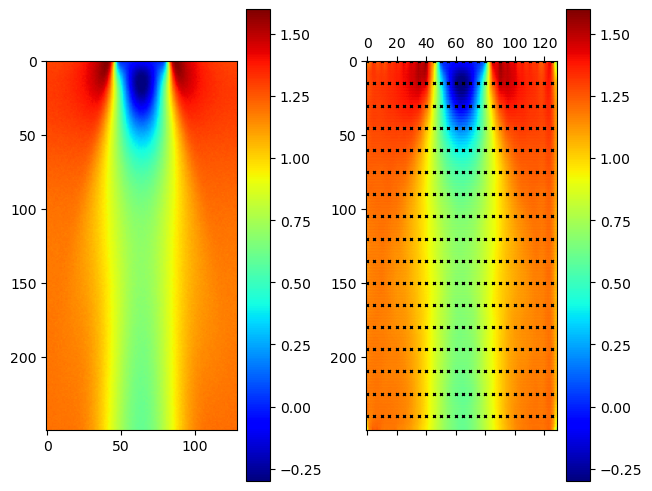

In [66]:
fig,axes = plt.subplots(1,2)
im0 = axes[0].imshow(jnp.mean(u_train_n,axis=0)[...,0],vmax=1.6,vmin=-0.3)
plt.colorbar(im0)
im1 = axes[1].imshow(jnp.mean(pred_train,axis=0)[...,0],vmax=1.6,vmin=-0.3)
axes[1].spy(observed_plot[t_plt,...,0],marker='x',markersize=2,c='k')
plt.colorbar(im1)
plt.show()

In [67]:
## residue averaged over time
rmse_true = np.mean((l_d_true+l_m_true[0,...]+l_m_true[1,...])**2)
rmse_pred = np.mean((l_d_test+l_m_test[0,...]+l_m_test[1,...])**2)
rmse_interp = np.sum(np.nan_to_num(interp_physics**2)/nb_elements)
rmse_noisy = np.mean((l_d_noisy+l_m_noisy[0,...]+l_m_noisy[1,...])**2)
print('Residual**2 averaged over space and time:')
print(f'True data: {rmse_true:.7f}')
print(f'pred data: {rmse_pred:.7f}')
print(f'interp data: {rmse_interp:.7f}')
print(f'noisy data: {rmse_noisy:.7f}')

Residual**2 averaged over space and time:
True data: 0.0259248
pred data: 0.6524026
interp data: 617.8768921
noisy data: 273.8460083


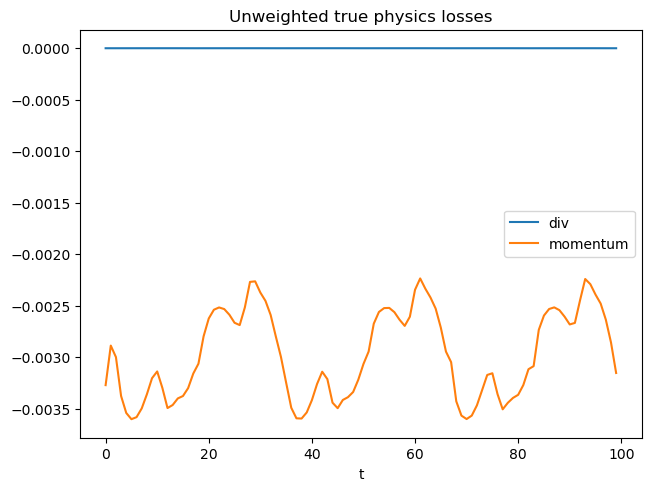

In [68]:
plt.figure()
plt.title('Unweighted true physics losses')
temp = np.mean(l_d_true,axis=[1,2])
plt.plot(temp,label='div')
temp = np.mean(np.sum(l_m_true,axis=0),axis=[1,2])
plt.plot(temp,label='momentum')
plt.legend()
plt.xlabel('t')
plt.show()

## Statistics

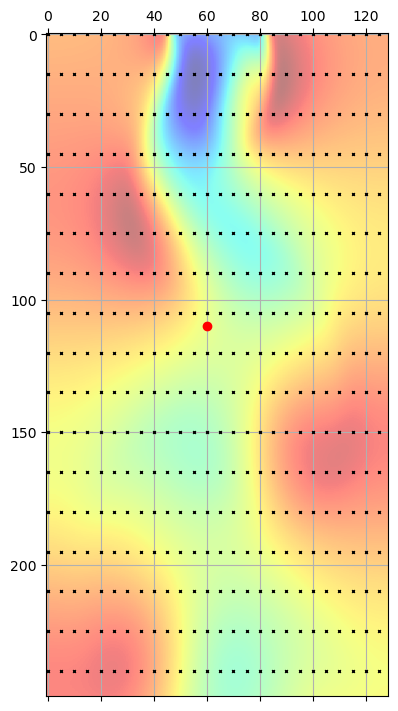

In [69]:
# probe location
probe_loc = [110,60]

fig = plt.figure(figsize=(5,7))
ax = fig.add_subplot(111)
ax.spy(observed_plot[t_plt,...,0],marker='x',markersize=2,c='k')
ax.imshow(ux_test[0,:,:],'jet',alpha=0.5)
ax.scatter(probe_loc[1],probe_loc[0],zorder=20,c='r')
ax.grid()
plt.show()

In [70]:
# Frequencies in true data
probe_ux_true = ux_test[:,probe_loc[0],probe_loc[1]]
probe_uy_true = uy_test[:,probe_loc[0],probe_loc[1]]
probe_p_true = pp_test[:,probe_loc[0],probe_loc[1]]

freq = np.fft.fftfreq(len(probe_ux_true),d=0.0002*1250)
f_ux_true = np.fft.fft(probe_ux_true-np.mean(probe_ux_true))/len(probe_ux_true)
f_uy_true = np.fft.fft(probe_uy_true-np.mean(probe_uy_true))/len(probe_uy_true)
f_p_true = np.fft.fft(probe_p_true-np.mean(probe_p_true))/len(probe_p_true)

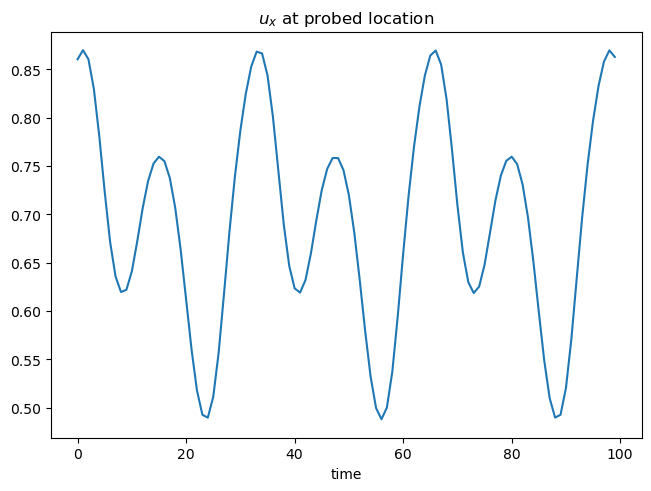

In [71]:
plt.figure()
plt.plot(probe_ux_true)
plt.title('$u_x$ at probed location')
plt.xlabel('time')
plt.show()

In [72]:
# frequencies
probe_ux_pred = pred_test[:,probe_loc[0],probe_loc[1],0]
probe_uy_pred = pred_test[:,probe_loc[0],probe_loc[1],1]
probe_p_pred = pred_test[:,probe_loc[0],probe_loc[1],2]

# freq = np.fft.fftfreq(len(probe_ux_pred),d=0.0002*1250)
f_ux_pred = np.fft.fft(probe_ux_pred-np.mean(probe_ux_pred))/len(probe_ux_pred)
f_uy_pred = np.fft.fft(probe_uy_pred-np.mean(probe_uy_pred))/len(probe_uy_pred)
f_p_pred = np.fft.fft(probe_p_pred-np.mean(probe_p_pred))/len(probe_p_pred)

# frequencies
probe_ux_interp = compare_interp[:,probe_loc[0],probe_loc[1],0]
probe_uy_interp = compare_interp[:,probe_loc[0],probe_loc[1],1]
probe_p_interp = compare_interp[:,probe_loc[0],probe_loc[1],2]

# freq = np.fft.fftfreq(len(probe_ux_interp),d=0.0002*1250)
f_ux_interp = np.fft.fft(probe_ux_interp-np.mean(probe_ux_interp))/len(probe_ux_interp)
f_uy_interp = np.fft.fft(probe_uy_interp-np.mean(probe_uy_interp))/len(probe_uy_interp)
f_p_interp = np.fft.fft(probe_p_interp-np.mean(probe_p_interp))/len(probe_p_interp)


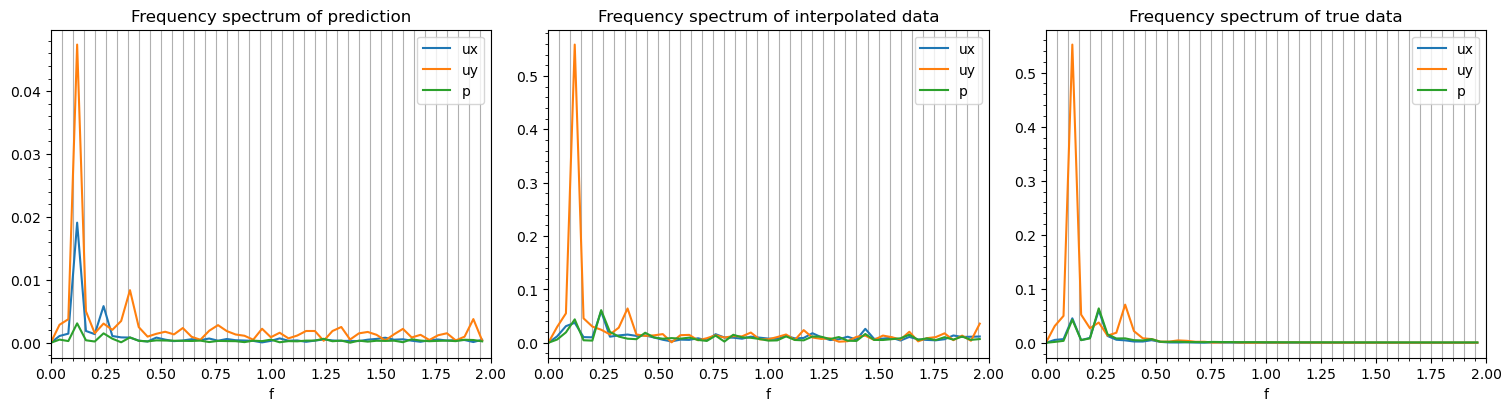

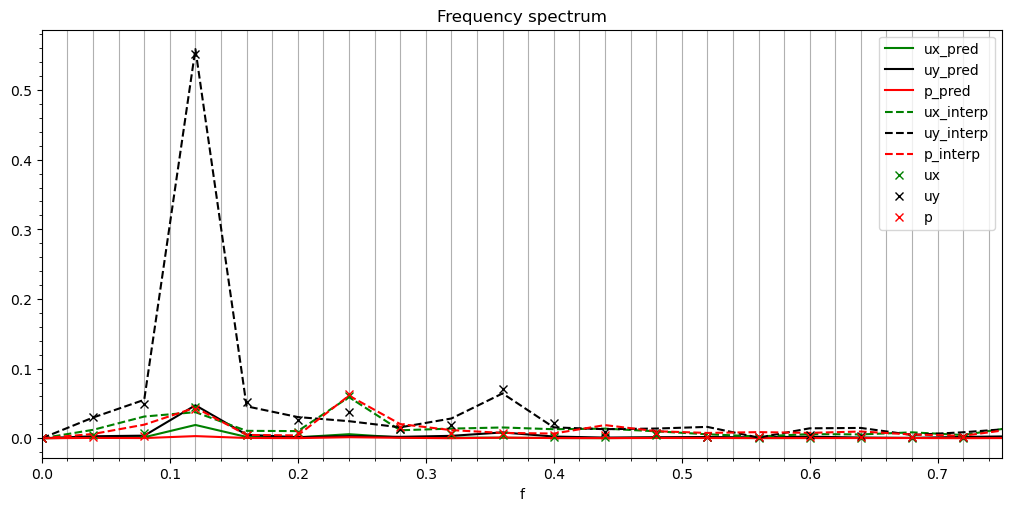

In [73]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].set(title='Frequency spectrum of prediction',xlabel='f',xlim=[0,2])
ax[0].plot(freq[:int(len(freq)/2)], np.abs(f_ux_pred)[:int(len(freq)/2)],label='ux')
ax[0].plot(freq[:int(len(freq)/2)], np.abs(f_uy_pred)[:int(len(freq)/2)],label='uy')
ax[0].plot(freq[:int(len(freq)/2)], np.abs(f_p_pred)[:int(len(freq)/2)],label='p')
ax[0].legend()
ax[0].minorticks_on()
ax[0].grid(True,which='both',axis='x')

ax[1].set(title='Frequency spectrum of interpolated data',xlabel='f',xlim=[0,2])
ax[1].plot(freq[:int(len(freq)/2)], np.abs(f_ux_interp)[:int(len(freq)/2)],label='ux')
ax[1].plot(freq[:int(len(freq)/2)], np.abs(f_uy_interp)[:int(len(freq)/2)],label='uy')
ax[1].plot(freq[:int(len(freq)/2)], np.abs(f_p_interp)[:int(len(freq)/2)],label='p')
ax[1].legend()
ax[1].minorticks_on()
ax[1].grid(True,which='both',axis='x')

ax[2].set(title='Frequency spectrum of true data',xlabel='f',xlim=[0,2])
ax[2].plot(freq[:int(len(freq)/2)], np.abs(f_ux_true)[:int(len(freq)/2)],label='ux')
ax[2].plot(freq[:int(len(freq)/2)], np.abs(f_uy_true)[:int(len(freq)/2)],label='uy')
ax[2].plot(freq[:int(len(freq)/2)], np.abs(f_p_true)[:int(len(freq)/2)],label='p')
ax[2].legend()
ax[2].minorticks_on()
ax[2].grid(True,which='both',axis='x')

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.set(title='Frequency spectrum', xlabel='f', xlim=[0,2])
ax.plot(freq[:int(len(freq)/2)], np.abs(f_ux_pred)[:int(len(freq)/2)],label='ux_pred',c='g',linestyle='-')
ax.plot(freq[:int(len(freq)/2)], np.abs(f_uy_pred)[:int(len(freq)/2)],label='uy_pred',c='k',linestyle='-')
ax.plot(freq[:int(len(freq)/2)], np.abs(f_p_pred)[:int(len(freq)/2)],label='p_pred',c='r',linestyle='-')
ax.plot(freq[:int(len(freq)/2)], np.abs(f_ux_interp)[:int(len(freq)/2)],label='ux_interp',c='g',linestyle='--')
ax.plot(freq[:int(len(freq)/2)], np.abs(f_uy_interp)[:int(len(freq)/2)],label='uy_interp',c='k',linestyle='--')
ax.plot(freq[:int(len(freq)/2)], np.abs(f_p_interp)[:int(len(freq)/2)],label='p_interp',c='r',linestyle='--')
ax.plot(freq[:int(len(freq)/2)], np.abs(f_ux_true)[:int(len(freq)/2)],label='ux',c='g',linestyle='',marker='x')
ax.plot(freq[:int(len(freq)/2)], np.abs(f_uy_true)[:int(len(freq)/2)],label='uy',c='k',linestyle='',marker='x')
ax.plot(freq[:int(len(freq)/2)], np.abs(f_p_true)[:int(len(freq)/2)],label='p',c='r',linestyle='',marker='x')
ax.minorticks_on()
ax.legend()
ax.grid(True,which='both',axis='x')
ax.set_xlim([0,0.75])

plt.show()

Compare mean squared error

In [74]:
print('Overall MSE for prediction in testing: ', losses.mse(pred_test,u_test))
mse_interp = np.sum(np.nan_to_num(compare_interp - u_test)**2)/nb_elements
print('Overall MSE for interpolation in testing: ', mse_interp)
print('Overall MSE for noisy testing set: ', losses.mse(u_test_n,u_test))

Overall MSE for prediction in testing:  0.07476722
Overall MSE for interpolation in testing:  3.3416976407586136
Overall MSE for noisy testing set:  0.015109822


In [75]:
"🤯 END 🤯"

'🤯 END 🤯'